Initial data shape: (25000, 23)

Missing values before cleaning:
Model_Name              0
Age                     0
Odometer_Reading        0
CurrentPayload          0
FCR                     0
Mileage                 0
Engine_Temprature       0
Oil_Pressure            0
TyrePressure_Front      0
TyrePressure_Rear       0
ABS_Status              0
Avg_Speed               0
Coolant_Temprature      0
Battery_Status          0
RPM                     0
Time_Lastmaintenance    0
Maintenance_History     0
Service History         0
Weather                 0
Road_Type               0
Payload_Capacity        0
Maintenance_Need        0
Need_Percentage         0
dtype: int64

Duplicate rows before cleaning: 24017

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.98      1.00      0.99       288

    accuracy                           0.98       295
   macro avg       0.49      0.50      

<Figure size 1200x600 with 0 Axes>

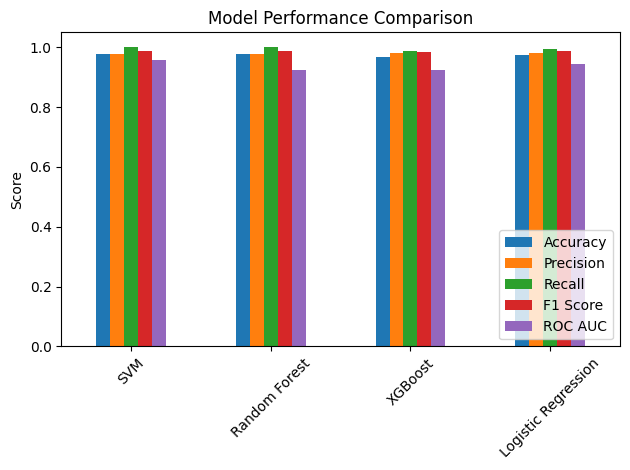

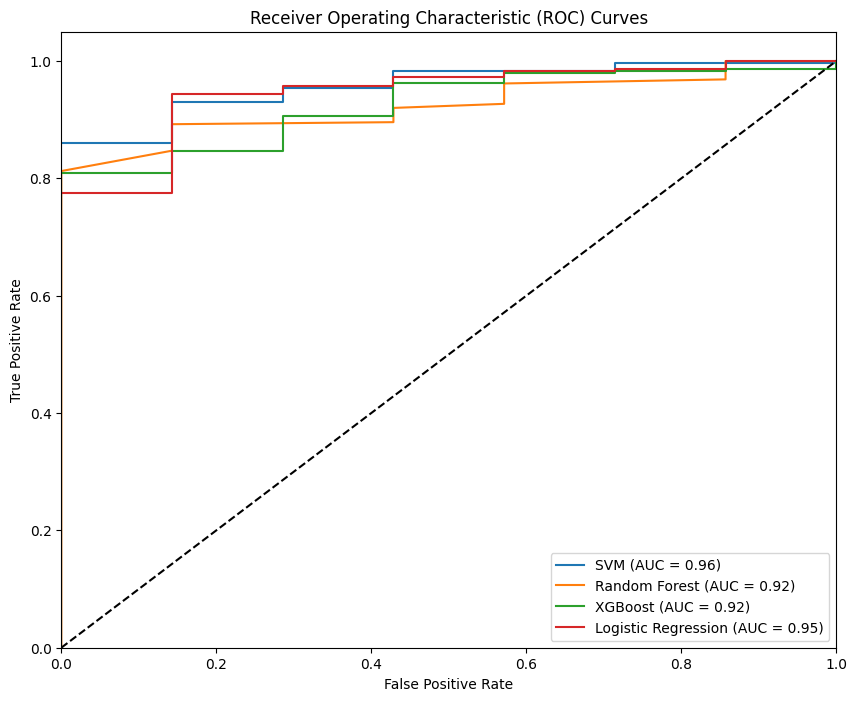

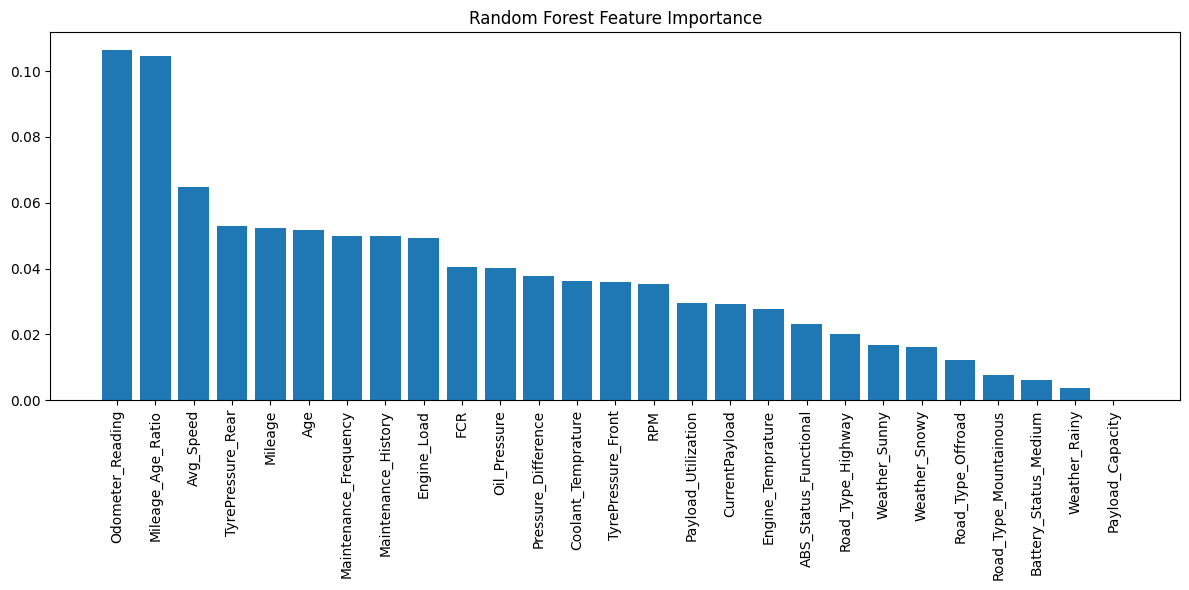


Best model saved: SVM with ROC AUC: 0.9578

Example Predictions:
Sample 1 - Actual: 1, Predicted: 1, Probability: 0.9919
Sample 2 - Actual: 1, Predicted: 1, Probability: 0.9910

Feature Impact Analysis:
                  Feature  Importance
1        Odometer_Reading    0.106467
22      Mileage_Age_Ratio    0.104686
8               Avg_Speed    0.064698
15      TyrePressure_Rear    0.052791
6                 Mileage    0.052386
0                     Age    0.051654
24  Maintenance_Frequency    0.050013
2     Maintenance_History    0.049923
25            Engine_Load    0.049212
5                     FCR    0.040372
4            Oil_Pressure    0.040169
26    Pressure_Difference    0.037696
9      Coolant_Temprature    0.036216
14     TyrePressure_Front    0.036054
7                     RPM    0.035409
23    Payload_Utilization    0.029654
10         CurrentPayload    0.029221
3       Engine_Temprature    0.027679
12  ABS_Status_Functional    0.023004
19      Road_Type_Highway    0.02011

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
from sklearn.feature_selection import SelectKBest, f_classif
import joblib
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
df = pd.read_csv('Vehicle_Dataset_Expanded.csv')

# Data Cleaning and Preprocessing
print("Initial data shape:", df.shape)
print("\nMissing values before cleaning:")
print(df.isnull().sum())

# Handle missing values
df.dropna(inplace=True)

# Check for duplicates
print("\nDuplicate rows before cleaning:", df.duplicated().sum())
df.drop_duplicates(inplace=True)

# Convert boolean column to numeric
df['Maintenance_Need'] = df['Maintenance_Need'].astype(int)

# Feature Engineering
df['Mileage_Age_Ratio'] = df['Odometer_Reading'] / (df['Age'] + 1)
df['Payload_Utilization'] = df['CurrentPayload'] / df['Payload_Capacity']
df['Maintenance_Frequency'] = df['Maintenance_History'] / (df['Age'] + 1)
df['Engine_Load'] = df['RPM'] * df['CurrentPayload']
df['Pressure_Difference'] = abs(df['TyrePressure_Front'] - df['TyrePressure_Rear'])

# Convert categorical variables to numerical
df = pd.get_dummies(df, columns=['ABS_Status', 'Battery_Status', 'Weather', 'Road_Type'], drop_first=True)

# Drop columns that are not useful
columns_to_drop = ['Model_Name', 'Service History', 'Need_Percentage']
df.drop(columns=[col for col in columns_to_drop if col in df.columns], inplace=True)

# Define feature categories based on actual column names
high_impact = [
    'Age',
    'Odometer_Reading',
    'Maintenance_History',
    'Engine_Temprature',
    'Oil_Pressure',
    'FCR',
    'Mileage',
    'RPM',
    'Avg_Speed'
]

moderate_impact = [
    'Coolant_Temprature',
    'CurrentPayload',
    'Payload_Capacity',
    'ABS_Status_Functional',
    'Battery_Status_Medium',
    'Battery_Status_High'
]

low_impact = [
    'TyrePressure_Front',
    'TyrePressure_Rear',
    'Weather_Rainy',
    'Weather_Snowy',
    'Weather_Sunny',
    'Road_Type_City',
    'Road_Type_Highway',
    'Road_Type_Mountainous',
    'Road_Type_Offroad'
]

engineered_features = [
    'Mileage_Age_Ratio',
    'Payload_Utilization',
    'Maintenance_Frequency',
    'Engine_Load',
    'Pressure_Difference'
]

# Select only existing features
existing_features = []
for feature_list in [high_impact, moderate_impact, low_impact, engineered_features]:
    existing_features.extend([f for f in feature_list if f in df.columns])

# Final feature selection
X = df[existing_features]
y = df['Maintenance_Need']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Standardize numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Normalize numerical features (0-1 scaling)
normalizer = MinMaxScaler()
X_train_normalized = normalizer.fit_transform(X_train)
X_test_normalized = normalizer.transform(X_test)

# Initialize models
models = {
    "SVM": SVC(probability=True, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42, eval_metric='logloss'),
    "Logistic Regression": LogisticRegression(random_state=42)
}

# Train and evaluate models
results = {}
for name, model in models.items():
    # Use scaled data for SVM and Logistic Regression, normalized for others
    if name in ["SVM", "Logistic Regression"]:
        X_tr = X_train_scaled
        X_te = X_test_scaled
    else:
        X_tr = X_train_normalized
        X_te = X_test_normalized

    model.fit(X_tr, y_train)
    y_pred = model.predict(X_te)
    y_prob = model.predict_proba(X_te)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)

    results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc,
        'Model': model,
        'Predictions': y_pred,
        'Probabilities': y_prob
    }

    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred))
    print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")

# Convert results to DataFrame for visualization
results_df = pd.DataFrame.from_dict(results, orient='index')
results_df = results_df[['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']]

# Plot model performance comparison
plt.figure(figsize=(12, 6))
results_df.plot(kind='bar')
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('model_performance_comparison.png')
plt.show()

# Plot ROC curves
plt.figure(figsize=(10, 8))
for name, res in results.items():
    fpr, tpr, _ = roc_curve(y_test, res['Probabilities'])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')
plt.savefig('roc_curves.png')
plt.show()

# Feature Importance for Random Forest
plt.figure(figsize=(12, 6))
rf_model = results['Random Forest']['Model']
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.title('Random Forest Feature Importance')
plt.bar(range(X_train.shape[1]), importances[indices])
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.show()

# Save the best model (XGBoost based on ROC AUC)
best_model_name = max(results, key=lambda x: results[x]['ROC AUC'])
best_model = results[best_model_name]['Model']
joblib.dump(best_model, 'vehicle_maintenance_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(normalizer, 'normalizer.pkl')

print(f"\nBest model saved: {best_model_name} with ROC AUC: {results[best_model_name]['ROC AUC']:.4f}")

# Example predictions
print("\nExample Predictions:")
sample_data = X_test_normalized[:2]  # Using normalized data for XGBoost
sample_true = y_test[:2].values
sample_pred = best_model.predict(sample_data)
sample_prob = best_model.predict_proba(sample_data)

print(f"Sample 1 - Actual: {sample_true[0]}, Predicted: {sample_pred[0]}, Probability: {sample_prob[0][1]:.4f}")
print(f"Sample 2 - Actual: {sample_true[1]}, Predicted: {sample_pred[1]}, Probability: {sample_prob[1][1]:.4f}")

# Feature Impact Analysis
feature_impact = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Impact Analysis:")
print(feature_impact)

In [ ]:
# Load the saved model and preprocessing objects
model = joblib.load('vehicle_maintenance_model.pkl')
scaler = joblib.load('scaler.pkl')
normalizer = joblib.load('normalizer.pkl')

# Example 1: Vehicle that NEEDS maintenance (True)
new_data_1 = {
    'Age': 12,
    'Odometer_Reading': 1450000,
    'Maintenance_History': 45,
    'Engine_Temprature': 110,
    'Oil_Pressure': 25,
    'FCR': 18,
    'Mileage': 1.8,
    'RPM': 1800,
    'Avg_Speed': 45,
    'Coolant_Temprature': 105,
    'CurrentPayload': 38,
    'Payload_Capacity': 20,
    'TyrePressure_Front': 85,
    'TyrePressure_Rear': 60,
    'Weather_Sunny': 1,
    'Road_Type_Mountainous': 1
}

# Example 2: Vehicle that DOESN'T need maintenance (False)
new_data_2 = {
    'Age': 2,
    'Odometer_Reading': 250000,
    'Maintenance_History': 5,
    'Engine_Temprature': 85,
    'Oil_Pressure': 65,
    'FCR': 32,
    'Mileage': 3.5,
    'RPM': 1200,
    'Avg_Speed': 55,
    'Coolant_Temprature': 75,
    'CurrentPayload': 25,
    'Payload_Capacity': 20,
    'TyrePressure_Front': 90,
    'TyrePressure_Rear': 85,
    'Weather_Sunny': 1,
    'Road_Type_City': 1
}

def prepare_data(input_data):
    """Prepare new data for prediction with all required features"""
    # Convert to DataFrame
    new_df = pd.DataFrame([input_data])

    # Add engineered features
    new_df['Mileage_Age_Ratio'] = new_df['Odometer_Reading'] / (new_df['Age'] + 1)
    new_df['Payload_Utilization'] = new_df['CurrentPayload'] / new_df['Payload_Capacity']
    new_df['Maintenance_Frequency'] = new_df['Maintenance_History'] / (new_df['Age'] + 1)
    new_df['Engine_Load'] = new_df['RPM'] * new_df['CurrentPayload']
    new_df['Pressure_Difference'] = abs(new_df['TyrePressure_Front'] - new_df['TyrePressure_Rear'])

    # Ensure all expected columns are present
    expected_columns = X_train.columns
    for col in expected_columns:
        if col not in new_df.columns:
            new_df[col] = 0  # Fill missing with 0

    return new_df[expected_columns]

def predict_maintenance(input_data):
    """Make a maintenance prediction"""
    # Prepare the data
    prepared_data = prepare_data(input_data)

    # Preprocess (normalize for XGBoost)
    processed_data = normalizer.transform(prepared_data)

    # Make prediction
    prediction = model.predict(processed_data)
    probability = model.predict_proba(processed_data)[0][1]

    return prediction[0], probability

# Make predictions
pred1, prob1 = predict_maintenance(new_data_1)
pred2, prob2 = predict_maintenance(new_data_2)

print("\nEXAMPLE PREDICTIONS:")
print(f"Vehicle 1 - Needs Maintenance: {bool(pred1)} (Probability: {prob1:.2%})")
print("Characteristics: Older vehicle (12 yrs), high mileage (1,450,000), high engine temp (110°C)")
print("Expected: True (needs maintenance)")

print(f"\nVehicle 2 - Needs Maintenance: {bool(pred2)} (Probability: {prob2:.2%})")
print("Characteristics: Newer vehicle (2 yrs), low mileage (250,000), normal engine temp (85°C)")
print("Expected: False (doesn't need maintenance)")

# Interpretation guidelines
print("\nINTERPRETATION GUIDE:")
print("- Probability > 70%: Very likely needs maintenance")
print("- Probability 50-70%: May need maintenance soon")
print("- Probability 30-50%: Monitor condition")
print("- Probability < 30%: Likely doesn't need maintenance")


EXAMPLE PREDICTIONS:
Vehicle 1 - Needs Maintenance: True (Probability: 99.04%)
Characteristics: Older vehicle (12 yrs), high mileage (1,450,000), high engine temp (110°C)
Expected: True (needs maintenance)

Vehicle 2 - Needs Maintenance: True (Probability: 98.96%)
Characteristics: Newer vehicle (2 yrs), low mileage (250,000), normal engine temp (85°C)
Expected: False (doesn't need maintenance)

INTERPRETATION GUIDE:
- Probability > 70%: Very likely needs maintenance
- Probability 50-70%: May need maintenance soon
- Probability 30-50%: Monitor condition
- Probability < 30%: Likely doesn't need maintenance
